In [3]:
!pip install tensorflow

In [1]:
#import librabries
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3

In [3]:
images_dataset=tf.keras.preprocessing.image_dataset_from_directory(
    'Train',
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
)

Found 1106 files belonging to 3 classes.


In [4]:
class_names = images_dataset.class_names
class_names

['Healthy', 'PM', 'TSWV']

In [5]:
#exploring the dataset
for image_batch, label_batch in images_dataset.take(1):
    print(image_batch.shape)
    print(label_batch.shape)

(32, 256, 256, 3)
(32,)


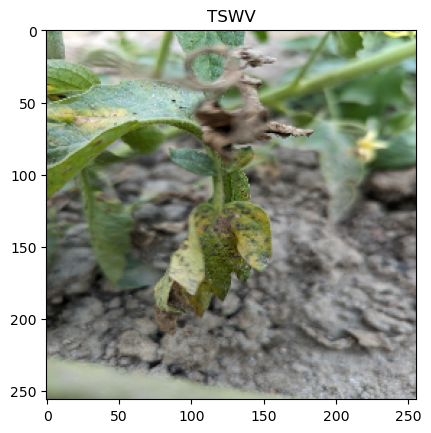

In [6]:
#visualize the first image in that batch
for image_batch, label_batch in images_dataset.take(9):
    plt.imshow(image_batch[0].numpy().astype('uint8'))
    plt.title(class_names[label_batch[0]])

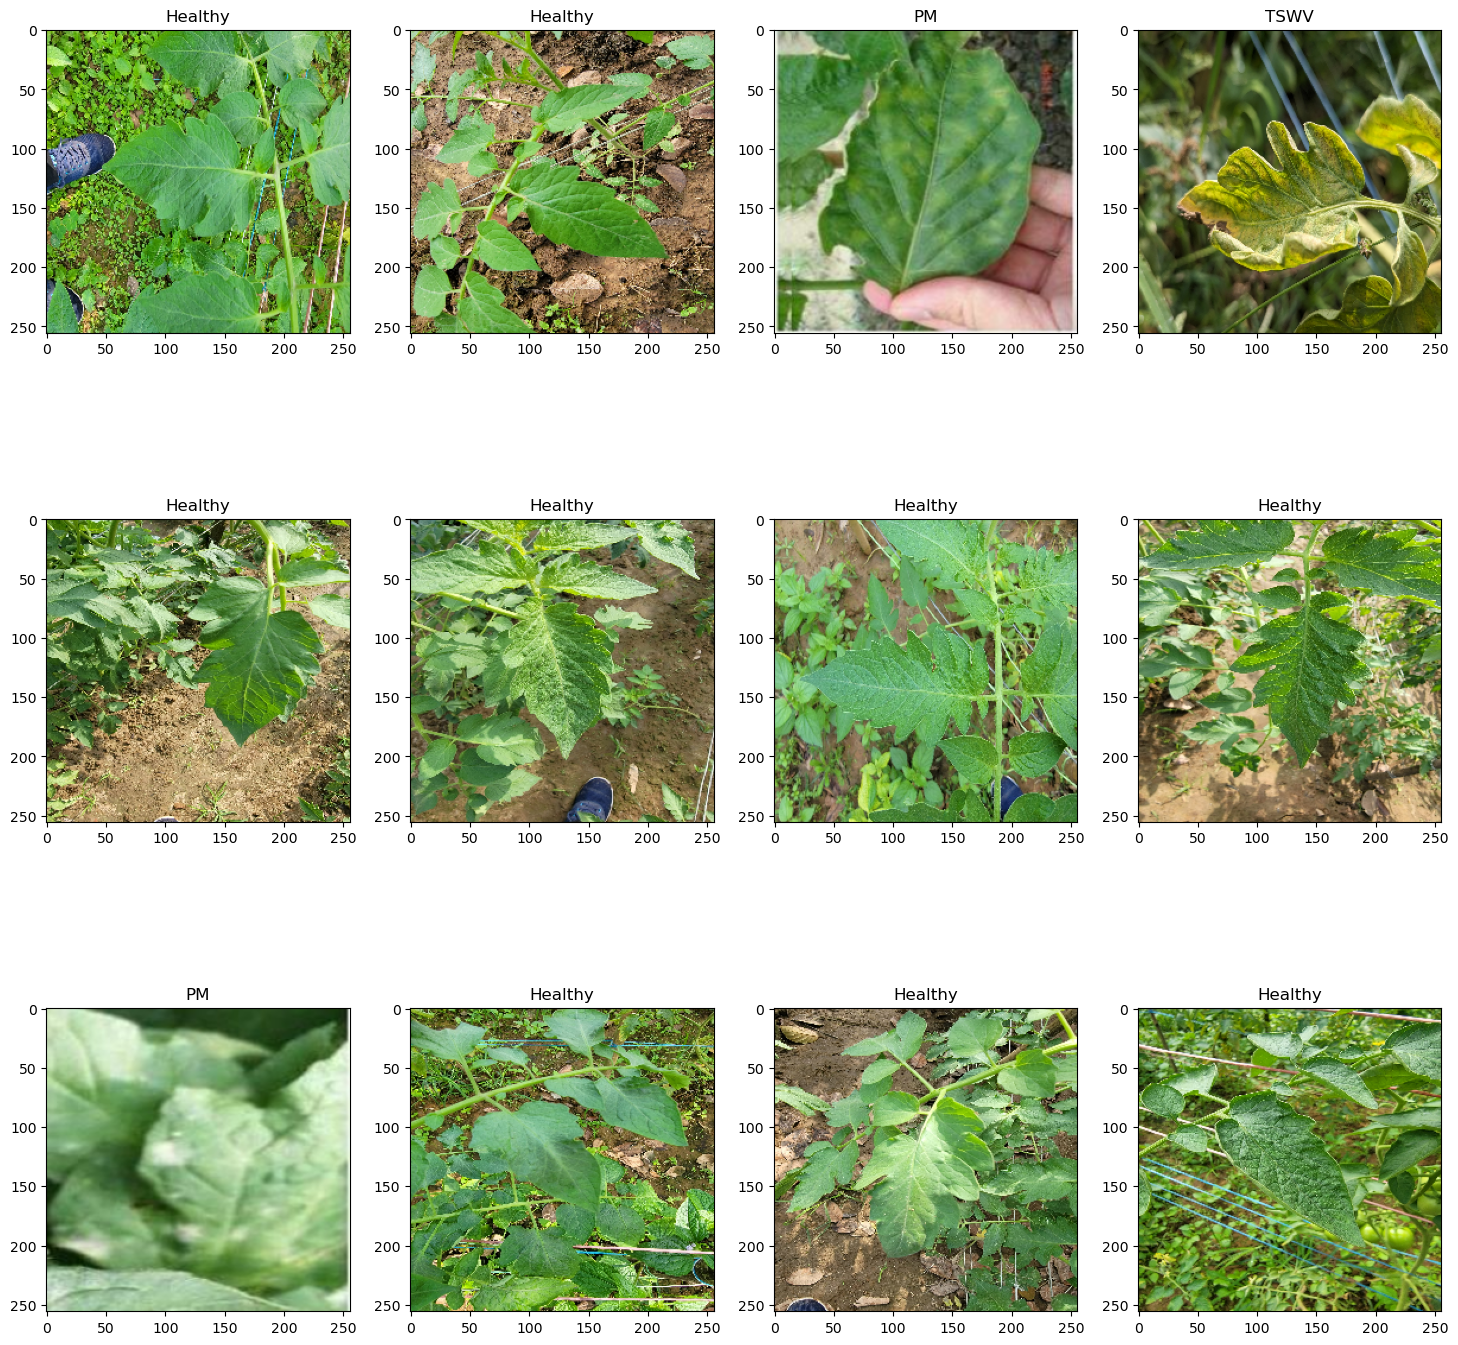

In [7]:
#visualize the first image in that batch
plt.figure(figsize=(18,18))
for image_batch, label_batch in images_dataset.take(1):
    for i in range (12):
        ax=plt.subplot(3,4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])

In [8]:
def get_dataset_partitions_tf(ds,train_split=0.8, val_split=0.1, test_split=0.1,shuffle=True, shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
        
    train_size= int(train_split* ds_size)
    val_size=int(val_split* ds_size)
    
    train_ds=ds.take(train_size)
    
    val_ds=ds.skip(train_size).take(val_size)
    
    test_ds=ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [9]:
train_ds, val_ds, test_ds=get_dataset_partitions_tf(images_dataset)

In [10]:
print(len(train_ds),len(val_ds),len(test_ds))

28 3 4


In [11]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [12]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [13]:
data_augmentation=tf.keras.Sequential([
    
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])


In [14]:
#building the model
input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes=3

model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(64,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')
])


model.build(input_shape=input_shape)

In [15]:
#GET SUMMARY OF THE MODEL
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [16]:
#compiling the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [17]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

#train the network with the given inputs and the corresponding labels
history=model.fit(
    train_ds,
    epochs=800,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds,
    callbacks=[es_callback]
)

Epoch 1/800


28/28 [==============================] - 85s 2s/step - loss: 0.9786 - accuracy: 0.5249 - val_loss: 0.8574 - val_accuracy: 0.5625
Epoch 2/800
28/28 [==============================] - 34s 1s/step - loss: 0.8113 - accuracy: 0.5873 - val_loss: 0.7224 - val_accuracy: 0.6354
Epoch 3/800
28/28 [==============================] - 34s 1s/step - loss: 0.6554 - accuracy: 0.7086 - val_loss: 0.6049 - val_accuracy: 0.7292
Epoch 4/800
28/28 [==============================] - 35s 1s/step - loss: 0.6077 - accuracy: 0.7200 - val_loss: 0.5368 - val_accuracy: 0.7604
Epoch 5/800
28/28 [==============================] - 35s 1s/step - loss: 0.5921 - accuracy: 0.7449 - val_loss: 0.8815 - val_accuracy: 0.6667
Epoch 6/800
28/28 [==============================] - 37s 1s/step - loss: 0.6388 - accuracy: 0.7234 - val_loss: 0.5453 - val_accuracy: 0.7708
Epoch 7/800
28/28 [==============================] - 38s 1s/step - loss: 0.5922 - accuracy: 0.7290 - val_loss: 0.5290 - val_accuracy: 0.7812
Epoch 8/800

# Save Model

In [ ]:

# Save the entire model as a SavedModel.
!mkdir -p saved_model
model.save('saved_model/my_model')

In [18]:
#evaluate the model
scores=model.evaluate(test_ds)

4/4 [==============================] - 23s 278ms/step - loss: 0.2612 - accuracy: 0.8906


In [19]:
print(history.params)

{'verbose': 1, 'epochs': 800, 'steps': 28}


In [20]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [21]:
len(history.history['accuracy'])

38

In [22]:
acc=(history.history['accuracy'])
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

Text(0.5, 1.0, 'Training and validation loss')

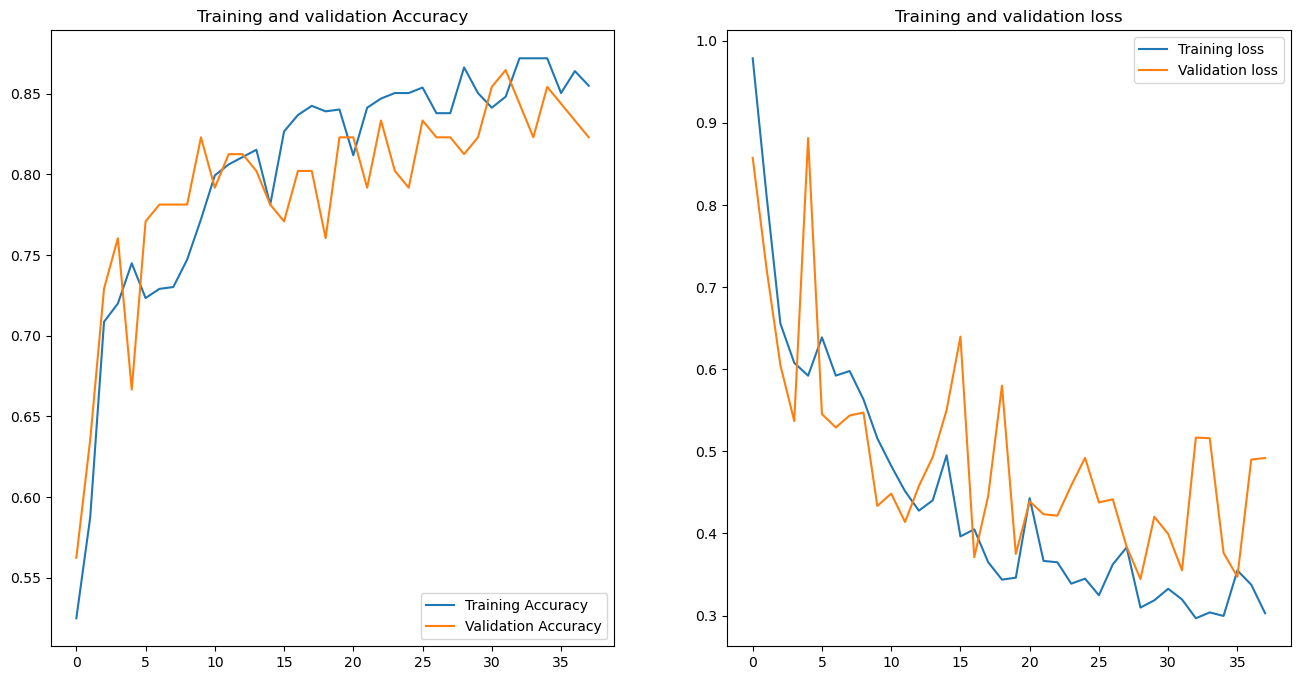

In [24]:
#plotting Accuracy and loss graph
plt.figure(figsize=(16, 8))
plt.subplot(1,2,1)
plt.plot(range(38),acc,label='Training Accuracy')
plt.plot(range(38),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and validation Accuracy')

#ploting traning and Validation loss
plt.subplot(1,2,2)
plt.plot(range(38),loss,label='Training loss')
plt.plot(range(38),val_loss,label='Validation loss')
plt.legend(loc='upper right')
plt.title('Training and validation loss')

In [27]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Assuming test_ds is your test dataset
true_labels = []
predicted_labels = []

for images, labels in test_ds:
    true_labels.extend(labels.numpy())
    predictions = model.predict(images)
    predicted_labels.extend(np.argmax(predictions, axis=1))

# Create the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("Confusion Matrix:")
print(conf_matrix)

# You can also print a classification report for more details
class_report = classification_report(true_labels, predicted_labels, target_names=class_names)
print("\nClassification Report:")
print(class_report)


1/1 [==============================] - 0s 274ms/step
Confusion Matrix:
[[74  0  1]
 [ 6 22  1]
 [ 3  3 18]]

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.89      0.99      0.94        75
          PM       0.88      0.76      0.81        29
        TSWV       0.90      0.75      0.82        24

    accuracy                           0.89       128
   macro avg       0.89      0.83      0.86       128
weighted avg       0.89      0.89      0.89       128



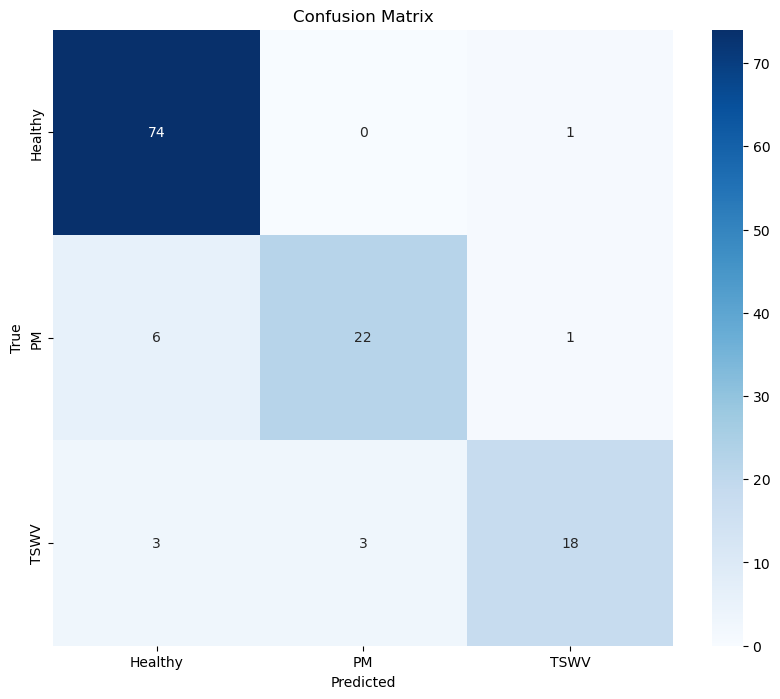

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming conf_matrix is your confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [30]:
import pandas as pd
from sklearn.metrics import classification_report

# Assuming class_report is your classification report string
class_report_dict = classification_report(true_labels, predicted_labels, target_names=class_names, output_dict=True)
class_report_df = pd.DataFrame(class_report_dict)

# Style the DataFrame for better visualization
styled_class_report = class_report_df.style.background_gradient(cmap='Blues', axis=0)

# Display the styled DataFrame
styled_class_report

In [31]:
from sklearn.metrics import classification_report

# Assuming class_report is your classification report string
class_report = classification_report(true_labels, predicted_labels, target_names=class_names)

print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.89      0.99      0.94        75
          PM       0.88      0.76      0.81        29
        TSWV       0.90      0.75      0.82        24

    accuracy                           0.89       128
   macro avg       0.89      0.83      0.86       128
weighted avg       0.89      0.89      0.89       128



## Save Model

In [32]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [33]:
from sklearn.metrics import classification_report
import pandas as pd

# Assuming class_report is your classification report string
class_report = classification_report(true_labels, predicted_labels, target_names=class_names, output_dict=True)

# Convert the classification report dictionary to a DataFrame
df = pd.DataFrame(class_report)

# Save the DataFrame to a CSV file
df.to_csv('classification_report.csv', index=False)

print("Classification Report saved to 'classification_report.csv'")

Classification Report saved to 'classification_report.csv'


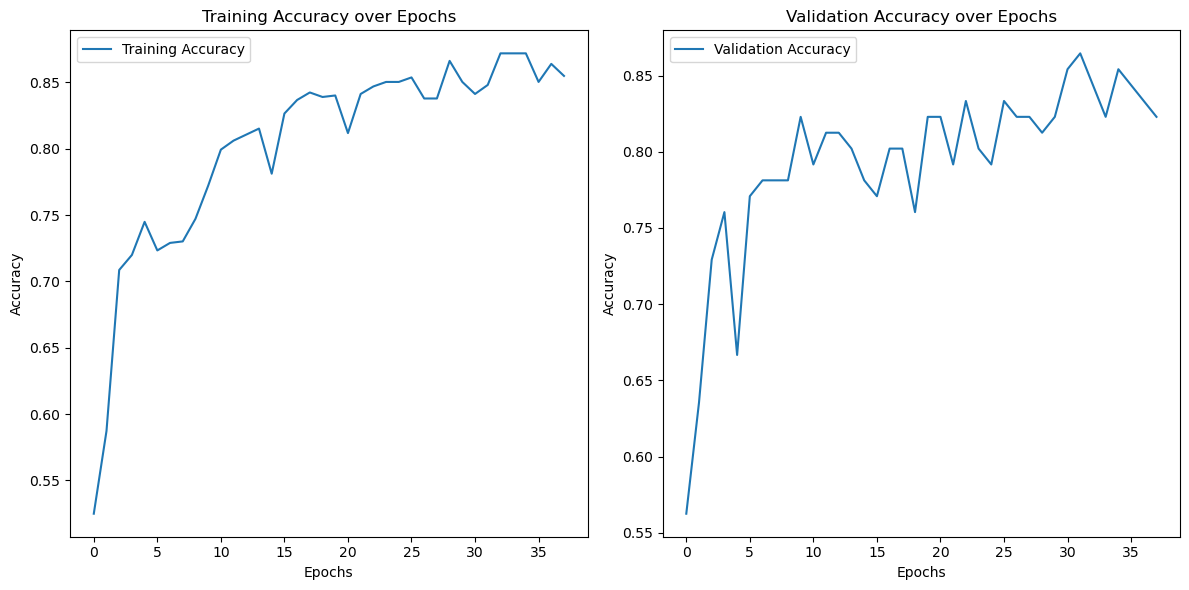

In [34]:
import matplotlib.pyplot as plt

# Assuming 'history' contains the training history
# Make sure you run the model.fit() with the variable 'history' assigned

# Plot F1 score
plt.figure(figsize=(12, 6))

# Training F1 score
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy over Epochs')
plt.legend()

# Validation F1 score
plt.subplot(1, 2, 2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


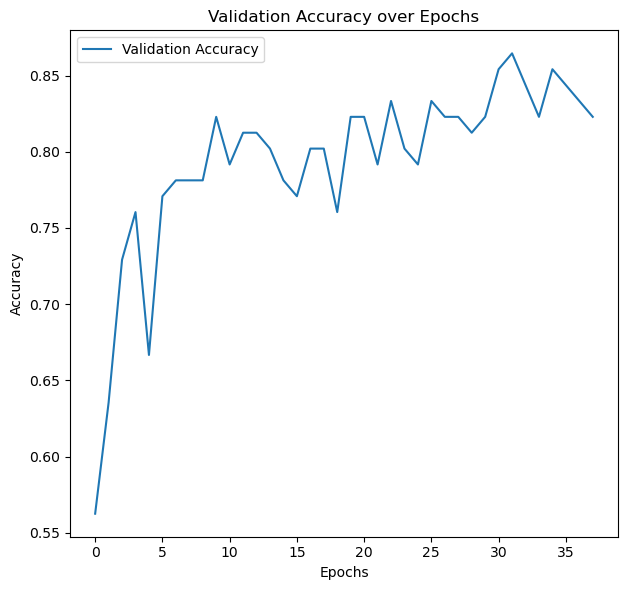

In [35]:
import matplotlib.pyplot as plt

# Assuming 'history' contains the training history
# Make sure you run the model.fit() with the variable 'history' assigned

# Plot F1 score and Validation Accuracy
plt.figure(figsize=(12, 6))

# Training F1 score
if 'f1_score' in history.history:
    plt.subplot(1, 2, 1)
    plt.plot(history.history['f1_score'], label='Training F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.title('Training F1 Score over Epochs')
    plt.legend()

# Validation Accuracy
if 'val_accuracy' in history.history:
    plt.subplot(1, 2, 2)
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy over Epochs')
    plt.legend()

plt.tight_layout()
plt.show()

In [36]:
# Assuming 'model' is your compiled model
learning_rate = model.optimizer.lr.numpy()

# Print the learning rate
print("Learning Rate:", learning_rate)

Learning Rate: 0.001


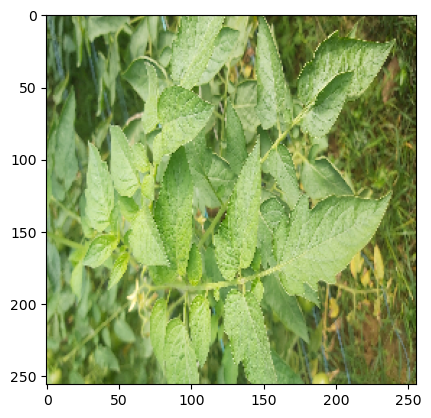

In [46]:
#making Predictions
for images_batch, label_batch in test_ds.take(1):
    plt.imshow(images_batch[0].numpy().astype('uint8'))

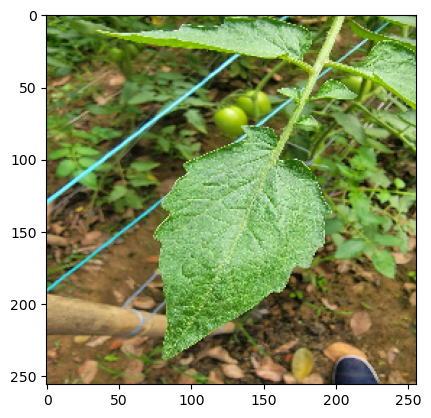

In [47]:
#making Predictions
for images_batch, label_batch in test_ds.take(1):
    plt.imshow(images_batch[0].numpy().astype('uint8'))

Predicting the first image
Image1 True Label: Healthy
(32, 256, 256, 3)
1/1 [==============================] - 1s 602ms/step
(32, 3)
Image1's predicated label: Healthy


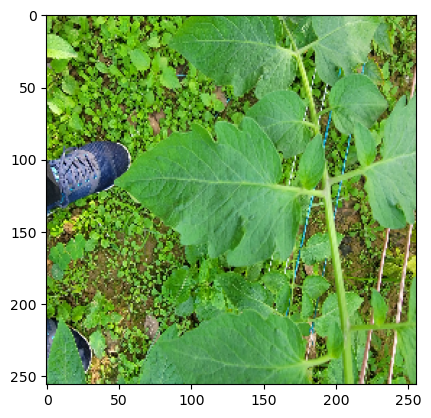

In [48]:
#making Predictions
for images_batch, label_batch in test_ds.take(1):
    image1=image_batch[0].numpy().astype('uint8')
    label1=label_batch[0].numpy()
    
    print("Predicting the first image")
    plt.imshow(image1)
    print('Image1 True Label:', class_names[label1])
    
    print(image_batch.shape)
    batch_prediction= model.predict(image_batch)
    print(batch_prediction.shape)
    print("Image1's predicated label:", class_names[np.argmax(batch_prediction[0])]) 

In [61]:
#function to predict with confidence
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)
    
    predictions=model.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 30ms/step


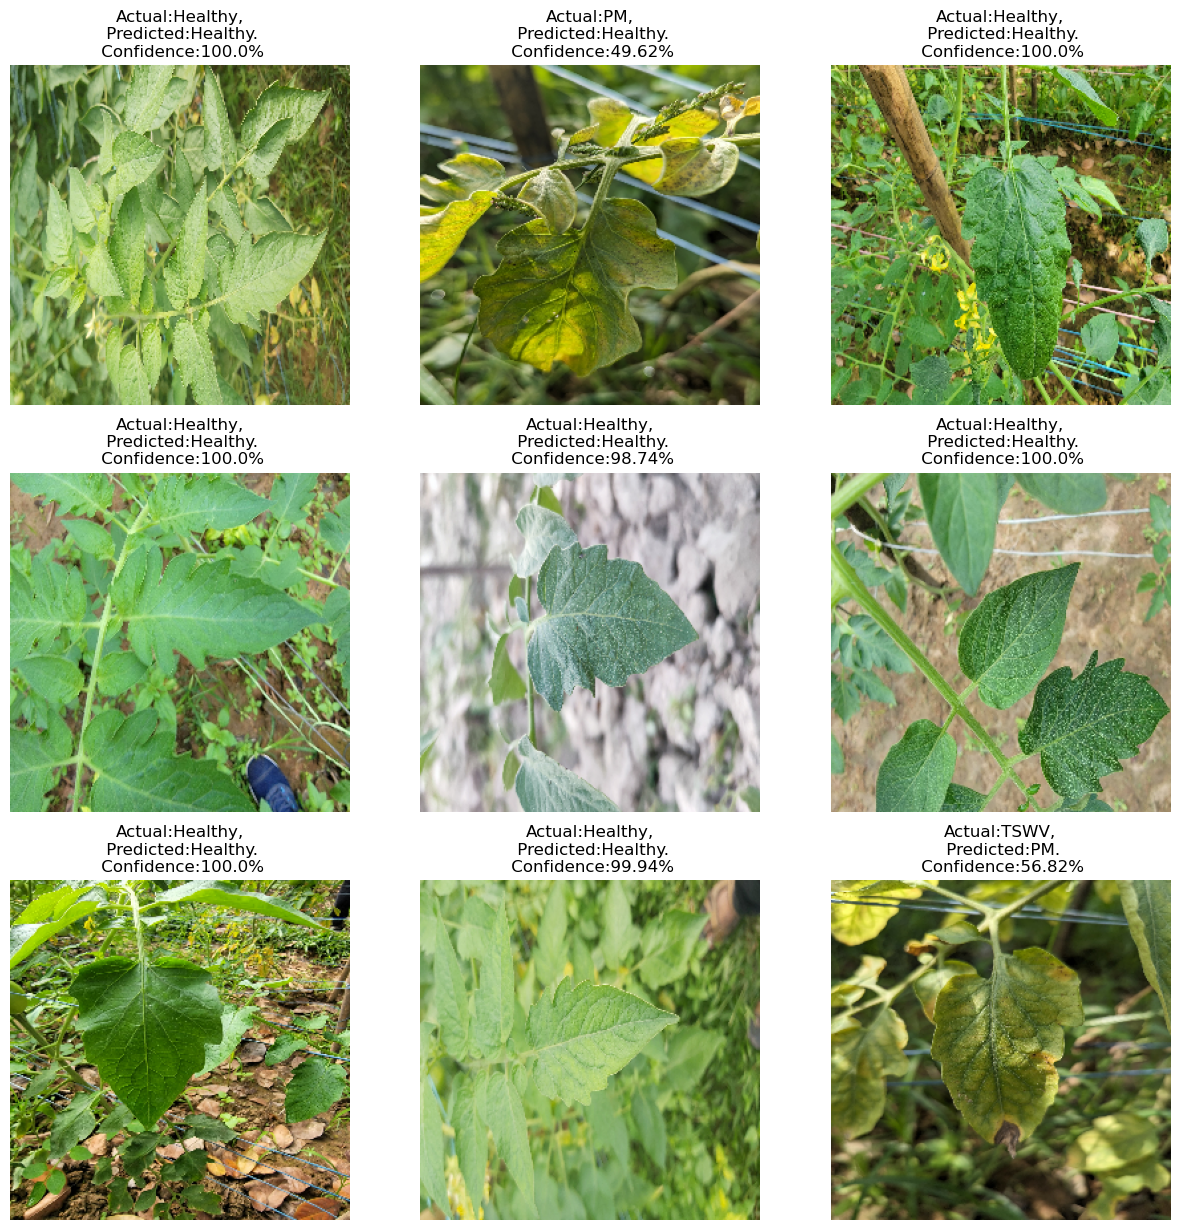

In [62]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range (9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class,confidence=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        plt.title(f"Actual:{actual_class},\n Predicted:{predicted_class}.\n Confidence:{confidence}%")
        plt.axis("off")

In [63]:
model_version=1
model.save(f"../saved_models/{model_version}")

INFO:tensorflow:Assets written to: ../saved_models/1\assets


INFO:tensorflow:Assets written to: ../saved_models/1\assets


In [64]:
import os 
model_version=max([int(i) for i in os.listdir("../saved_models") + [0]])+1
model.save(f"../saved_models/{model_version}")

INFO:tensorflow:Assets written to: ../saved_models/4\assets


INFO:tensorflow:Assets written to: ../saved_models/4\assets


In [65]:
model.save("../tomatoes2.h5")

C:\Users\sakib\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
